In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

D:\Programas\Anaconda\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', 'bdc4c6cdcb0a4dc493b8fccd929d351f')

In [33]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [34]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [35]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [36]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

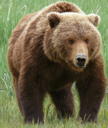

In [37]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'grizzly','black','teddy','polar'
path = Path('bears')

In [39]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
fns = get_image_files(path)
fns

(#428) [Path('bears/black/00000000.JPG'),Path('bears/black/00000002.jpg'),Path('bears/black/00000003.jpg'),Path('bears/black/00000004.jpg'),Path('bears/black/00000006.jpg'),Path('bears/black/00000008.jpg'),Path('bears/black/00000010.jpeg'),Path('bears/black/00000011.jpg'),Path('bears/black/00000012.jpeg'),Path('bears/black/00000013.jpeg')...]

In [41]:
failed = verify_images(fns)
failed

(#2) [Path('bears/grizzly/00000095.jpeg'),Path('bears/polar/00000074.jpg')]

In [42]:
failed.map(Path.unlink);

In [10]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
dls = bears.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


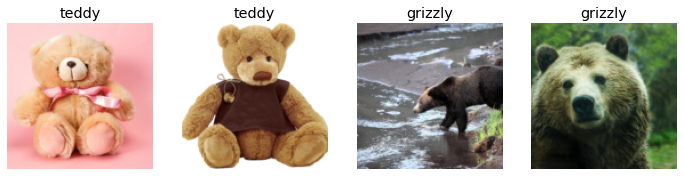

In [12]:
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


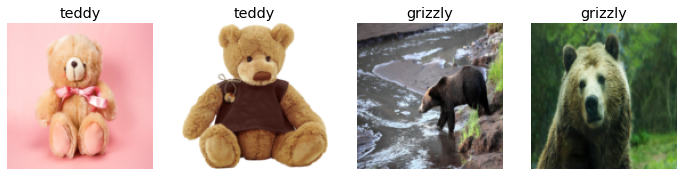

In [13]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


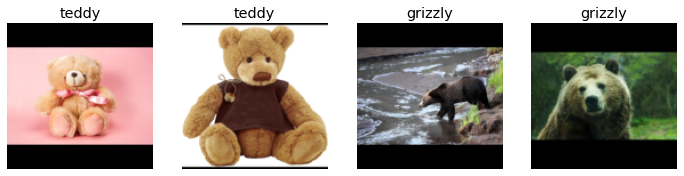

In [14]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


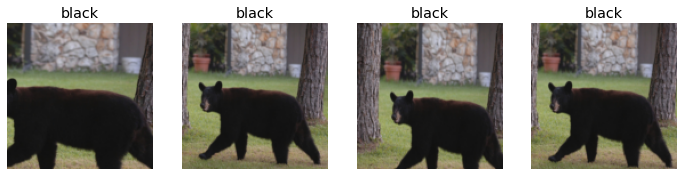

In [15]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


D:\Programas\Anaconda\lib\site-packages\torch\_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


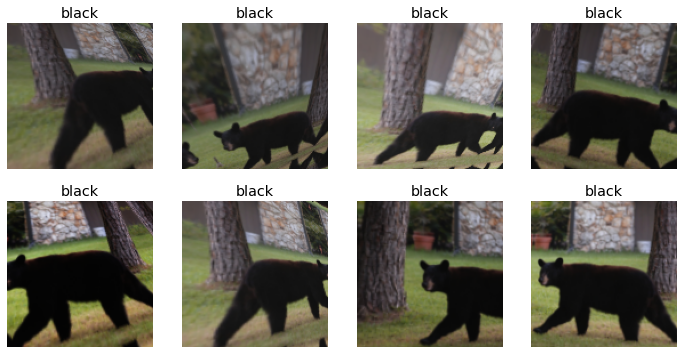

In [16]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [17]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [18]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.706840,0.148826,0.047059,01:14


D:\Programas\Anaconda\lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
D:\Programas\Anaconda\lib\site-packages\PIL\TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


epoch,train_loss,valid_loss,error_rate,time
0,0.230096,0.167643,0.047059,01:27
1,0.144173,0.140660,0.023529,01:23
2,0.122528,0.149588,0.023529,01:24
3,0.098030,0.145192,0.023529,01:22


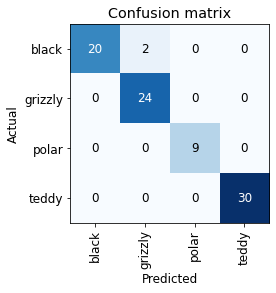

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

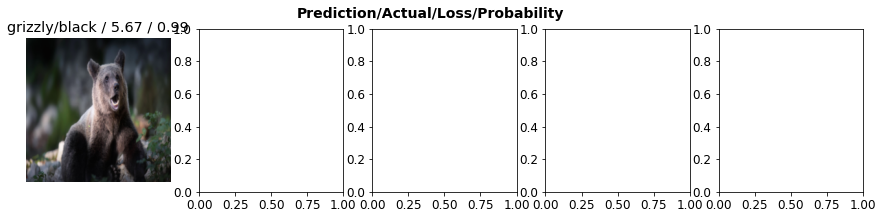

In [53]:
interp.plot_top_losses(5, nrows=1)

In [54]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [2]:
learn.export()

NameError: name 'learn' is not defined

In [56]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [57]:
learn_inf = load_learner(path/'export.pkl')

In [58]:
learn_inf.predict('images/grizzly.jpg')

('grizzly',
 TensorBase(1),
 TensorBase([2.9291e-06, 9.9999e-01, 1.7214e-06, 4.8196e-07]))

In [59]:
learn_inf.dls.vocab

['black', 'grizzly', 'polar', 'teddy']

In [60]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [61]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [62]:
img = PILImage.create(btn_upload.data[-1])

In [63]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [64]:
pred,pred_idx,probs = learn_inf.predict(img)

In [65]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [71]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [72]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [73]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [76]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [77]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
Enabling: voila
- Writing config: D:\Programas\Anaconda\etc\jupyter
    - Validating...
      voila 0.3.1 ok
